---
layout: post
title: Counting Ones Problem
excerpt: An introduction to genetic algorithms, via the Counting Ones Problem.
date: 2024-10-06
updatedDate: 2024-10-06
tags:
  - post
  - code
---

### What is a genetic algorithm?

Genetic algorithms are a subset of evolutionary algorithms, in which we simulate the process of natural selection to evolve a population of solutions to a problem. To accomplish this, we need to represent the solutions in a way that allows us to perform the processes of natural selection (e.g. selection, mutation, and crossover operations).

One common way to represent solutions in genetic algorithms is to use binary strings (e.g. `b'01010101'` is an 8-bit binary string). Each bit in the string represents a different aspect of the solution, and we can use the tools of combinatorics to efficiently create large numbers of diverse solutions.




### The "Counting Ones Problem"

As a simple example, we could simply begin with a random bitstring, and then iteratively apply mutation and selection operations to evolve the bitstring towards a target bitstring, in our case, a bitstring of all 1s.

Let's define the solution space formally.

$$
\text{Let } X = \{x_i\}_{i=1}^n \text{ where } x_i \in \{0, 1\} \\
$$

This is a way to say that we have a bitstring $X$ of length $n$, where each bit in the bitstring is either a 0 or a 1.


### Defining a fitness function

When iterating on solutions, we need a way to evaluate how good a solution is. One common approach is to assign a fitness score to the solution, which we can use to select the fittest solutions for keeping in the next generation.

Keeping our solution simple, and sticking to the name "Counting Ones Problem", let's define our fitness function $F(x)$ as the number of 1s in the binary representation of $X$.

$$
f(X) = \sum_{i=1}^{n} x_i
$$


We can take a look some example scores from the fitness function $f(X)$ for a few values of $X$, when $n = 3$. When a bit is 1, it contributes 1 to the score, and when a bit is 0, it doesn't

| $X$ | $f(X)$ |
| --- | --- |
| `000` | 0 |
| `001` | 1 |
| `110` | 2 |
| `111` | 3 |


### The algorithm

Now that we have defined the solution space $X$ and our fitness function $F(X)$, we want to find the value of $X$ that maximizes the fitness function $F(X)$.

We can use a genetic algorithm to find this value.

> **💡 Note: you may find this example trivial, and that's because it is! The Counting Ones Problem is a classic problem in genetic algorithms, and it is a good way to understand the basic concepts of genetic algorithms.**

#### Steps

* We initialize a random value $X_t = X_0$
* Each generation we **mutate** the current value $X_{t-1}$ to get a new value $X_t$. (more on this in the [Mutation section](#mutation))

* We then calculate the fitness of the new value $X_t$ and compare it to the fitness of the previous value $X_{t-1}$, and select the value with the highest fitness to be the current value $X_t$.
* We repeat this process until the fitness of the current value $X_t$ is equal to the total number of bits $n$, i.e. until $F(X_t) = n$ or $X_t = \{1, 1, \dots, 1\}$.

#### Mutation

* To mutate the current value, we flip each bit with a probability of $1/n$.
* This means that each bit has an equal chance of being flipped from a 0 to a 1 or a 1 to a 0. The expected number of bits flipped is $1$, but it's possible that no bits are flipped, or all bits are flipped.

Let's implement this in code.


### Implementation

We'll need to import a few libraries to help us with our implementation.

In [1]:
from random import randint, seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bits = 8

In [2]:
def Fitness(value: np.uint8) -> int:
    return value.bit_count()

In [3]:
def flip_bit(value: np.uint8, index: np.uint8) -> np.uint8:
    """Flip a specific bit in the given integer value."""
    return value ^ (1 << index)

def mutate(value: np.uint8) -> np.uint8:
    """Mutate the given integer value by flipping all bits with a probability of 1/bits."""
    for i in range(bits):
        if np.random.random() < 1/bits:
            value = flip_bit(value, i)
    return value

def adapt(value: np.uint8, target: np.uint8) -> np.uint8:
    """Adapt the given value towards the target by either keeping it or mutating it."""
    return max(value, mutate(value), key=lambda x: Fitness(x))

Now we've defined the `Fitness` function for evaluating solutions, and we have the `mutate` and `adapt` functions for evolving the solutions.

We'll initialize a random value $X_0$ and a target value $X_T$, and then iteratively apply the `adapt` function to evolve the solution towards the target.

In [15]:
seed(1)
initial_value: np.uint8 = randint(0, 2**bits - 1)
target: np.uint8 = 2**bits - 1

print(f"Initial value: \t{initial_value:0{bits}b}")
print(f"Target value: \t{target:0{bits}b}")

value = initial_value
generation = 0
value_history = [value]
while Fitness(value, target) < bits:
    value = adapt(value, target)
    value_history.append(value)
    generation += 1

df = pd.DataFrame(np.array([value_history]).T, columns=['Value'])
df['bitstring'] = df['Value'].apply(lambda x: f"{x:0{bits}b}")
df['fitness'] = df['Value'].apply(lambda x: Fitness(x, target))
df['generation'] = df.index
df.head()

Initial value: 	01000100
Target value: 	11111111


,Value,bitstring,fitness,generation
0,68,01000100,2,0
1,68,01000100,2,1
2,69,01000101,3,2
3,69,01000101,3,3
4,77,01001101,4,4


And now, some plots to visualize the evolution of the solutions.

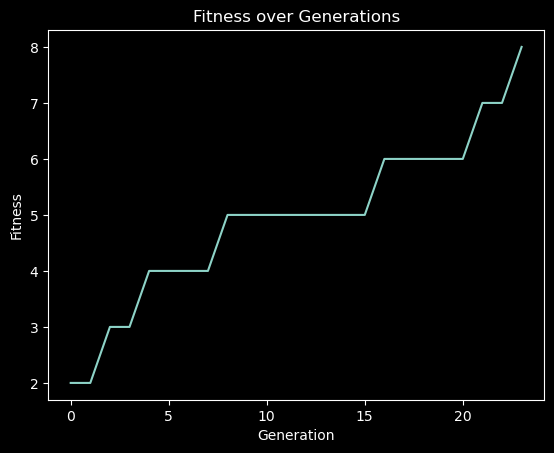

In [16]:
plt.plot(df['generation'], df['fitness'])
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.show()


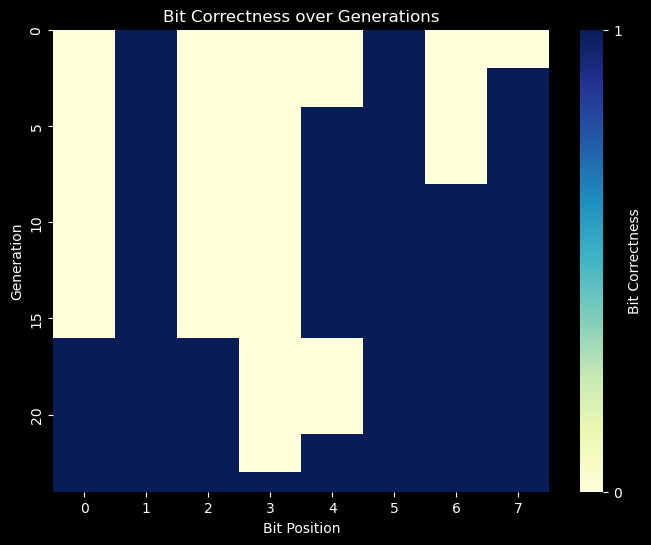

In [17]:
# Create a binary matrix where 1 represents a correct bit and 0 represents an incorrect bit
binary_matrix = df['bitstring'].apply(lambda x: [int(bit) == int(target_bit) for bit, target_bit in zip(x, f"{target:0{bits}b}")])
heatmap_data = np.array(binary_matrix.tolist())

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Bit Correctness', 'ticks': [0, 1]})

plt.title('Bit Correctness over Generations')
plt.xlabel('Bit Position')
plt.ylabel('Generation')

plt.yticks(np.arange(0, len(df), 5), df['generation'][::5])
plt.xticks(np.arange(0.5, bits + 0.5), range(bits))

plt.show()


One thing I like about this particular example is how around generation 15, the algorithm drops the 1 in position 4, in exchange for 2 1s in positions 0 and 2. This illustrates the stochastic nature of the algorithm, and demonstrates the tradeoffs between exploration and exploitation, a key phenomenon in the study of evolutionary algorithms.

### Conclusion

This was a simple example to introduce the concept of genetic algorithms, and to showcase the power of these algorithms to evolve solutions to problems. We used a bitstring representation of the solutions, and a fitness function that counted the number of 1s in the bitstring. We then iteratively applied mutation and selection operations to evolve the solutions towards the target bitstring of all 1s.

### Future work

What if we were targeting a particular bitstring, e.g. `10110110`, instead of all 1s?

What if the bitstring represented a real number, or multiple real numbers, and our fitness function depended on those values nonlinearly?

What if we included crossover operations into the algorithm?